In [ ]:
from typing import TypedDict, Annotated, List, Literal, Sequence, Optional, Dict
from typing_extensions import TypedDict
from pydantic import BaseModel
import json
from IPython.display import display, Markdown, HTML

from langchain_core.messages import BaseMessage, HumanMessage, AIMessage
from langgraph.graph import StateGraph, START, END
from langchain_core.prompts import SystemMessagePromptTemplate, HumanMessagePromptTemplate, MessagesPlaceholder, PromptTemplate, BasePromptTemplate
from langchain_core.prompts import ChatPromptTemplate
from langchain_core.tools import tool
from langgraph.types import Command, interrupt
from langgraph.checkpoint.memory import MemorySaver
from langgraph.prebuilt import ToolNode, tools_condition
from langgraph.graph.message import add_messages
from langsmith import traceable

import matplotlib.pyplot as plt
import base64
from io import BytesIO

import requests
from bs4 import BeautifulSoup
import re
from datetime import datetime

import numpy as np
from langchain.agents import AgentExecutor
from langchain.agents import create_tool_calling_agent
from langchain.tools import Tool
from langchain_community.utilities import GoogleSerperAPIWrapper
from langchain_community.utilities import OpenWeatherMapAPIWrapper
from langchain_google_genai import ChatGoogleGenerativeAI

from dotenv import load_dotenv
import os

# Marketing Chatbot

In [2]:
class ResearchState(TypedDict):
    message: Annotated[List[BaseMessage], add_messages]
    intent: Optional[str]

    product_description: Optional[str]
    product_type: Optional[str]
    target_market_region: Optional[str]
    target_customer_profile: Optional[str]
    problem_to_solve: Optional[str]
    business_goal: Optional[str]
    budget: Optional[str]
    timeline: Optional[str]
    your_unique_point: Optional[str]
    competitors: Optional[str]

    strategy_content: Optional[str]
    market_analysis: Optional[str]
    gantt_chart: Optional[str]
    gantt_tasks: Optional[List[dict]]

    information_needed: List[str]
    informationisEnough: Optional[bool]
    errors: Annotated[List[str], add_messages]
    final_report: Optional[str]
    current_field: Optional[str]

# Helper Functions

In [ ]:
# Help LLM identify missing fields to generate questionss
def get_field_description(field: str) -> str:
    """Get field descriptions for context"""
    descriptions = {
        "product_description": "Mô tả chi tiết về sản phẩm hoặc dịch vụ",
        "product_type": "Loại hình sản phẩm (ứng dụng, dịch vụ, sản phẩm vật lý, v.v.)",
        "target_market_region": "Khu vực thị trường mục tiêu (địa lý)",
        "target_customer_profile": "Hồ sơ khách hàng lý tưởng (đặc điểm)",
        "problem_to_solve": "Vấn đề cụ thể mà sản phẩm giải quyết cho khách hàng",
        "business_goal": "Mục tiêu kinh doanh và marketing cụ thể",
        "budget": "Ngân sách dự kiến cho dự án",
        "timeline": "Thời gian dự kiến thực hiện dự án",
        "your_unique_point": "Điểm khác biệt và lợi thế cạnh tranh",
        "competitors": "Đối thủ cạnh tranh chính trong thị trường"
    }
    return descriptions.get(field, field)

def get_collected_info_context(state: ResearchState) -> str:
    """Get context of already collected information"""
    fields = ["product_description", "product_type", "target_market_region",
                        "target_customer_profile", "problem_to_solve", "business_goal", 
                        "budget", "timeline", "your_unique_point", "competitors"]

    context_lines = []  # save description

    for field in fields:
        value = state.get(field)  # Get field value from state

        if value:
            description = get_field_description(field)
            context_lines.append(f"- {description}: {value}")

    # Join all context lines into a single string
    if context_lines:
        return "\n".join(context_lines)
    else:
        return "Chưa có thông tin nào được thu thập."

# Generate final report
def generate_report(state: ResearchState) -> str:
    """Generate final comprehensive report"""
    base64_image = state.get("gantt_chart")

    report = f"""
<h2>BÁO CÁO PHÂN TÍCH KINH DOANH</h2>

<h3>I. THÔNG TIN SẢN PHẨM</h3>
<ul>
  <li><strong>Mô tả:</strong> {state.get('product_description')}</li>
  <li><strong>Loại sản phẩm:</strong> {state.get('product_type')}</li>
  <li><strong>Thị trường:</strong> {state.get('target_market_region')}</li>
  <li><strong>Khách hàng:</strong> {state.get('target_customer_profile')}</li>
  <li><strong>Vấn đề giải quyết:</strong> {state.get('problem_to_solve')}</li>
</ul>

<h3>II. CHIẾN LƯỢC KINH DOANH</h3>
<div>{state.get('strategy_content')}</div>

<h3>III. PHÂN TÍCH THỊ TRƯỜNG</h3>
<div>{state.get('market_analysis')}</div>

<h3>IV. THỜI GIAN THỰC HIỆN</h3>
<div>
  <img src="data:image/png;base64,{base64_image}" alt="Biểu đồ Gantt" style="max-width: 100%; height: auto;" />
</div>
"""
    return display(HTML(report))

def initialize_llm():
    """Initialize and return the LLM client"""
    return ChatGoogleGenerativeAI(
            model="gemini-2.0-flash",
            temperature=0,
            max_tokens=None,
            timeout=None,
            max_retries=2,
)

# Competitors Company Info/Data
def company_info_validation(state: ResearchState) -> str:
    """Validate and enrich company information using external sources"""
    print("Đang kiểm tra thông tin công ty...")
    company_name = state.get("competitors")
    if not company_name:
        state["errors"].append("Không có tên công ty để kiểm tra.")
        return state

    search_query = f"Thông tin về công ty {company_name} tại {state.get('target_market_region')}" 
    search_results = search_tool.func(search_query)

    return search_results

def competitor_data_enrichment(state: ResearchState) -> str:
    """Fetch and enrich competitor data using external sources"""
    print("Đang lấy dữ liệu đối thủ cạnh tranh...")
    competitors = state.get("competitors")
    if not competitors:
        state["errors"].append("Không có thông tin đối thủ để kiểm tra.")
        return state
    search_query = f"Phân tích đối thủ cạnh tranh: {competitors} tại {state.get('target_market_region')}" 
    search_results = search_tool.func(search_query)

    return search_results

In [ ]:
load_dotenv()
api_key = os.getenv("GOOGLE_API_KEY")
os.environ["GOOGLE_API_KEY"] = api_key
llm = initialize_llm()

search = GoogleSerperAPIWrapper()
search_tool = Tool(
    name="google_search",
    func=search.run,
    description="Use this tool to search Google using Serper API.",
    return_direct=True
)

# Nodes

In [ ]:
def classify_intent_node(state: ResearchState) -> ResearchState:
    """Use LLM to classify the user's intent from the latest message."""
    print("Classifying user intent")

    last_message = state["message"][-1] if state["message"] else None

    # Check if there is a last message and if it is a HumanMessage
    if not last_message or not isinstance(last_message, HumanMessage):
        state["intent"] = None
        return state

    prompt = ChatPromptTemplate.from_template("""
Bạn là một trợ lý phân loại ý định người dùng.
Dựa vào câu truy vấn của người dùng, hãy phân phân loại nó vào **một trong hai nhóm sau**:
1. marketing_report — Người dùng muốn tạo **báo cáo chiến lược marketing** hoặc thực hiện phân tích có cấu trúc liên quan đến chiến lược marketing.
2. general_question — Người dùng đang hỏi một câu hỏi **chung chung hoặc không liên quan**, không nhằm mục đích tạo báo cáo marketing.

Nhiệm vụ của bạn là CHỈ trả về DUY NHẤT một trong hai chuỗi: "marketing_report" hoặc "general_question"

Đây là câu truy vấn của người dùng: {user_message}
    """
    )

    messages = prompt.format_messages(user_message=last_message.content)
    result = llm.invoke(messages)
    intent = result.content.strip().split()[0]

    state["intent"] = intent
    print(f"Intent classified: {intent}")
    return state

# General Question Answering Node
def chatbot_node(state: ResearchState) -> ResearchState:
    """Answers general questions using the LLM"""
    print("Chatbot node processing")
    ai_response = llm.invoke(state["message"])
    state["message"].append(ai_response)
    print(f"\nAI: {ai_response.content}")
    return state

# Node Functions to get information
def generate_question_node(state: ResearchState) -> ResearchState:
    """Generate contextual question for the current field"""
    if not state.get("information_needed"):
        state["informationisEnough"] = True
        return state

    current_field = state["information_needed"][0]
    state["current_field"] = current_field
    
    # Get context of collected information
    collected_context = get_collected_info_context(state) # All the fields already collected
    field_description = get_field_description(current_field)
    

    prompt = ChatPromptTemplate.from_template("""
    Bạn là một chuyên gia tư vấn kinh doanh. Nhiệm vụ của bạn là tạo câu hỏi tự nhiên để thu thập thông tin về: {field_description}
    Chỉ tạo DUY NHẤT 1 câu hỏi để thu thập thông tin.
                                            
    THÔNG TIN ĐÃ THU THẬP:
    {collected_info}

    YÊU CẦU:
    1. Tạo câu hỏi tự nhiên, không cứng nhắc
    2. Sử dụng thông tin đã có để làm câu hỏi có ngữ cảnh
    3. Tránh lặp lại thông tin đã biết nằm trong collected_info

    CHỈ trả về câu hỏi, không có text thêm.
    """)
    
    messages = prompt.format_messages(
        field_description=field_description,
        collected_info=collected_context
    )
    
    result = llm.invoke(messages)
    question = result.content.strip()
    
    # Add question to conversation
    ai_message = AIMessage(content=question)
    state["message"].append(ai_message)
    
    print(f"\n{question}")
    return state

def validate_response_node(state: ResearchState) -> ResearchState:
    """Validate if user response is relevant and extract information"""
    # If no information is needed, mark as enough
    if not state.get("information_needed"):
        state["informationisEnough"] = True
        return state
    
    # Check if we have a message and current field
    message = state.get("message")
    current_field = state.get("current_field")

    if message is None or current_field is None:
        return state
    
    # Check last user message
    last_message = state["message"][-1]
    if not isinstance(last_message, HumanMessage):
        return state
    
    # Get user response and field description
    user_response = last_message.content
    current_field = state["current_field"]
    field_description = get_field_description(current_field)
    
    validation_prompt = ChatPromptTemplate.from_template("""
    Phân tích xem câu trả lời của người dùng có liên quan và đủ thông tin cho câu hỏi không.

    THÔNG TIN CẦN THU THẬP: {field_description}
    
    CÂU TRẢ LỜI CỦA NGƯỜI DÙNG: {user_response}

    Trả về JSON format chính xác:
    {{
        "is_relevant": true/false,
        "extracted_info": "thông tin đã trích xuất" hoặc ""
    }}

    TIÊU CHÍ ĐÁNH GIÁ:
    - is_relevant: true nếu câu trả lời có thông tin liên quan đến field cần thu thập HOẶC nếu người dùng không có thông tin nào để cung cấp
    - extracted_info: rút ra những thông tin hữu ích từ câu trả lời của người dùng và sửa lại câu từ cho phù hợp và hay hơn
    CHỈ trả về JSON, không có text khác.
    """)

    messages = validation_prompt.format_messages(
        field_description=field_description,
        user_response=user_response
    )

    try:
        result = llm.invoke(messages)
        response_json = result.content.strip()

        # Clean JSON response
        if response_json.startswith('```'):
            response_json = response_json.split('```')[1]
            if response_json.startswith('json'):
                response_json = response_json[4:]

        validation_result = json.loads(response_json)

        is_relevant = validation_result.get("is_relevant", False)
        extracted_info = validation_result.get("extracted_info", "").strip()
        # is_sufficient = validation_result.get("is_sufficient", False)
        # clarification = validation_result.get("clarification_question", "")

        print(is_relevant)
        # ======= CASE 1: Thông tin liên quan và đầy đủ =======
        if is_relevant and extracted_info:
            state[current_field] = extracted_info
            if current_field in state["information_needed"]:
                state["information_needed"].remove(current_field)

            print(f"Đã lưu {field_description}: {extracted_info}")

            # Kiểm tra xem đã đủ thông tin chưa
            if not state["information_needed"]:
                state["informationisEnough"] = True
                done_msg = "Tuyệt vời! Tôi đã có đủ thông tin. Bây giờ tôi sẽ phân tích và tạo báo cáo cho bạn..."
                state["message"].append(AIMessage(content=done_msg))
                print(f"🎉 {done_msg}")

        # ======= CASE 2: Có liên quan nhưng chưa đủ thông tin =======
        # elif is_relevant and not is_sufficient:
        #     state[current_field] = extracted_info
        #     followup = clarification
        #     state["message"].append(AIMessage(content=followup))
        #     print(f"🔍 {followup}")

        # ======= CASE 3: Không liên quan =======
        else:
            response_msg = f"Tôi hiểu, nhưng tôi cần thông tin về {field_description.lower()}."
            # response_msg += " " + (clarification or f"Bạn có thể chia sẻ thông tin về {field_description.lower()} không?")
            state["message"].append(AIMessage(content=response_msg))
            print(f"❓ {response_msg}")

    # ======= CASE 4: Lỗi parse JSON từ LLM =======
    except json.JSONDecodeError as e:
        print(f"❌ Lỗi phân tích JSON: {e}")
        print(f"Raw response: {response_json}")

        # Nếu user trả lời có vẻ ổn thì vẫn lưu tạm
        if len(user_response.strip()) > 10:
            state[current_field] = user_response.strip()
            state["information_needed"] = [
                f for f in state["information_needed"] if f != current_field
            ]
            print(f"🔄 Fallback: Đã lưu {field_description}: {user_response.strip()}")
        else:
            retry_msg = f"Bạn có thể chia sẻ thêm thông tin về {field_description.lower()} không?"
            state["message"].append(AIMessage(content=retry_msg))
            print(f"🔄 {retry_msg}")

    return state

def final_report_node(state: ResearchState) -> ResearchState:
    """Generate and display final report"""
    report = generate_report(state)
    state["final_report"] = report
    print(report)
    return state

# Analyze Nodes
def strategy_analysis_node(state: ResearchState) -> ResearchState:
    """Create business strategy"""
    print("Phân tích chiến lược kinh doanh")

    search_query = f"Chiến lược kinh doanh cho sản phẩm {state.get('product_type')} tại {state.get('target_market_region')}, khách hàng: {state.get('target_customer_profile')}"
    search_results = search_tool.func(search_query)

    # Get strategy content
    strategy_prompt = ChatPromptTemplate.from_template("""
    Dựa trên thông tin sản phẩm sau, hãy tạo nội dung chiến lược kinh doanh chi tiết:

    Sản phẩm: {product_description}
    Loại: {product_type}
    Thị trường: {target_market_region}
    Khách hàng: {target_customer_profile}
    Vấn đề giải quyết: {problem_to_solve}
    Mục tiêu: {business_goal}
    Ngân sách: {budget}
    Thời gian: {timeline}
    Điểm khác biệt: {unique_point}
    Đối thủ: {competitors}

    Kết quả tìm kiếm liên quan:
    {search_results}

    Hãy tạo chiến lược logic bao gồm:
    1. Định vị sản phẩm
    2. Chiến lược tiếp thị
    3. Kế hoạch phát triển
    4. Chiến lược cạnh tranh
    5. Roadmap thực hiện chi tiết

    Trả lời bằng tiếng Việt, chi tiết và chuyên nghiệp. Vào vấn đề chính ngay từ đầu. Không cần mở đầu dài dòng
    Viết dưới dạng HTML với các tiêu đề rõ ràng. ĐƯỢC ĐẶT nằm trong <div> tags. Không được sử dụng dấu *
    """)
    # 

    strategy_messages = strategy_prompt.format_messages(
        product_description=state.get('product_description'),
        product_type=state.get('product_type'),
        target_market_region=state.get('target_market_region'),
        target_customer_profile=state.get('target_customer_profile'),
        problem_to_solve=state.get('problem_to_solve'),
        business_goal=state.get('business_goal'),
        budget=state.get('budget'),
        timeline=state.get('timeline'),
        unique_point=state.get('your_unique_point'),
        competitors=state.get('competitors'),
        search_results=search_results
    )
    
    strategy_result = llm.invoke(strategy_messages)
    if strategy_result.content.startswith("```"):
        # Remove the triple backticks and optional 'html' label
        strategy_result.content = strategy_result.content.split("```")[1]
        if strategy_result.content.startswith("html"):
            strategy_result.content = strategy_result.content[4:]
        strategy_result.content = strategy_result.content.strip()

    state["strategy_content"] = strategy_result.content

    print("Hoàn thành phân tích chiến lược")
    return state

def gantt_task_extract_node(state: ResearchState) -> ResearchState:
    """Extract tasks for Gantt chart from strategy analysis"""
    
    # Extract tasks for Gantt chart
    tasks_prompt = ChatPromptTemplate.from_template("""
    Dựa trên thông tin dự án và thời gian thực hiện, hãy tạo danh sách tasks cho biểu đồ Gantt:

    Thời gian thực hiện: {timeline}
    Sản phẩm: {product_description}
    Loại sản phẩm: {product_type}
    Ngân sách: {budget}
    Mục tiêu: {business_goal}

    Trả về CHÍNH XÁC format JSON sau, không thêm text gì khác:
    [
        {{"name": "Tên nhiệm vụ 1", "start": 0, "duration": 2}},
        {{"name": "Tên nhiệm vụ 2", "start": 1, "duration": 3}},
        {{"name": "Tên nhiệm vụ 3", "start": 3, "duration": 2}}
    ]

    Trong đó:
    - name: Tên nhiệm vụ bằng tiếng Việt
    - start: Tháng bắt đầu (từ 0)
    - duration: Số tháng thực hiện

    Tạo 6-8 nhiệm vụ hợp lý cho dự án này. Các nhiệm vụ có thể chồng lấn về thời gian. 
    CHỈ trả về JSON, không có text thêm.
    """)
    
    tasks_messages = tasks_prompt.format_messages(
        timeline=state.get('timeline'),
        product_description=state.get('product_description'),
        product_type=state.get('product_type'),
        budget=state.get('budget'),
        business_goal=state.get('business_goal')
    )
    
    tasks_result = llm.invoke(tasks_messages)
    
    try:
        
        tasks_json = tasks_result.content.strip()
        # Remove any potential markdown formatting
        if tasks_json.startswith('```'):
            tasks_json = tasks_json.split('```')[1]
            if tasks_json.startswith('json'):
                tasks_json = tasks_json[4:]
        
        tasks = json.loads(tasks_json)
        state["gantt_tasks"] = tasks
        print(f"Đã tạo {len(tasks)} nhiệm vụ cho Gantt chart")
        
    except json.JSONDecodeError as e:
        print(f"Lỗi parse JSON: {e}")

    print("Hoàn thành phân tích task Gantt")
    return state

def market_analysis_node(state: ResearchState) -> ResearchState:
    """Analyze market situation"""
    print("Phân tích tình hình thị trường")

    search_query = f"Phân tích thị trường của {state.get('product_description')} tại {state.get('target_market_region')}"
    search_results = search_tool.func(search_query)

    competitor_company = company_info_validation(state)
    competitor_information = competitor_data_enrichment(state)

    prompt = ChatPromptTemplate.from_template("""
    Dựa trên thông tin sau, hãy thực hiện phân tích thị trường chi tiết:

    Sản phẩm: {product_description}
    Thị trường: {target_market_region}
    Khách hàng: {target_customer_profile}
    Đối thủ: {competitors}
    Ngân sách: {budget}

    Kết quả tìm kiếm về thị trường:
    {search_results}             
    Thông tin công ty đối thủ:
    {competitor_company}   
    Thông tin chi tiết về đối thủ:
    {competitor_information}

    Phân tích bao gồm:
    1. Quy mô và tiềm năng thị trường
    2. Xu hướng thị trường hiện tại
    3. Phân khúc khách hàng
    4. Phân tích đối thủ cạnh tranh
    5. Cơ hội và thách thức
    6. Đề xuất các từ khóa và chủ đề cần nghiên cứu thêm trên web

    Trả lời dựa trên dữ liệu thực tế và xu hướng hiện tại. Vào vấn đề chính ngay từ đầu. Không cần mở đầu dài dòng. 
    Viết dưới dạng HTML với các tiêu đề rõ ràng. ĐƯỢC ĐẶT nằm trong <div> tags. Không được sử dụng dấu *
    """)

    messages = prompt.format_messages(
        product_description=state.get('product_description', ''),
        target_market_region=state.get('target_market_region', ''),
        target_customer_profile=state.get('target_customer_profile', ''),
        competitors=state.get('competitors', ''),
        budget=state.get('budget', ''),
        search_results=search_results,
        competitor_company=competitor_company,
        competitor_information=competitor_information
    )

    result = llm.invoke(messages)
    
    if result.content.startswith("```"):
        # Remove the triple backticks and optional 'html' label
        result.content = result.content.split("```")[1]
        if result.content.startswith("html"):
            result.content = result.content[4:]
        result.content = result.content.strip()

    state["market_analysis"] = result.content
    return state

def create_gantt_chart_node(state: ResearchState) -> ResearchState:
    """Create Gantt chart using tasks from strategy analysis"""
    print("Tạo biểu đồ Gantt")
    
    try:
        # Get tasks from strategy analysis
        tasks = state.get("gantt_tasks", [])
        
        if not tasks:
            print("Không có tasks từ strategy analysis")
            state["gantt_chart"] = "Lỗi: Không có dữ liệu tasks"
            return state
        
        fig, ax = plt.subplots(figsize=(14, len(tasks) + 2))
        
        # Colors for different tasks
        colors = plt.cm.Set3(np.linspace(0, 1, len(tasks)))
        
        # Plot each task
        for i, (task, color) in enumerate(zip(tasks, colors)):
            name = task.get('name', f'Task {i+1}')
            start = task.get('start', 0)
            duration = task.get('duration', 1)
            
            # Create bar for task
            ax.barh(i, duration, left=start, color=color, alpha=0.7, height=0.6)
            
            # Add task name inside or beside the bar
            text_x = start + duration/2 if duration > 2 else start + duration + 0.1
            ax.text(text_x, i, name, ha='center' if duration > 2 else 'left', 
                   va='center', fontweight='bold', fontsize=10)
        
        # Customize chart
        ax.set_xlabel('Tháng', fontsize=12, fontweight='bold')
        ax.set_ylabel('Nhiệm vụ', fontsize=12, fontweight='bold')
        ax.set_title('Biểu đồ Gantt - Kế hoạch thực hiện dự án', 
                    fontsize=14, fontweight='bold', pad=20)
        
        # Set y-axis
        ax.set_yticks(range(len(tasks)))
        ax.set_yticklabels([f'Task {i+1}' for i in range(len(tasks))])
        ax.invert_yaxis()  # Top to bottom
        
        # Set x-axis
        max_time = max([task.get('start', 0) + task.get('duration', 1) for task in tasks])
        ax.set_xlim(0, max_time + 2)
        ax.set_xticks(range(0, max_time + 3))
        
        # Add grid
        ax.grid(axis='x', alpha=0.3, linestyle='--')
        ax.grid(axis='y', alpha=0.1)
        
        # Add timeline info
        timeline_info = state.get('timeline', 'Không xác định')
        ax.text(0.02, 0.98, f'Tổng thời gian dự án: {timeline_info}', 
               transform=ax.transAxes, fontsize=10, 
               bbox=dict(boxstyle='round', facecolor='lightblue', alpha=0.5),
               verticalalignment='top')
        
        # plt.tight_layout()
        # chart_path = 'gantt_chart.png'
        # plt.savefig(chart_path, dpi=300, bbox_inches='tight', 
        #            facecolor='white', edgecolor='none')
        # plt.close()
        
        # state["gantt_chart"] = chart_path

        plt.tight_layout()
        buf = BytesIO()
        plt.savefig(buf, format='png', dpi=300, bbox_inches='tight', facecolor='white', edgecolor='none')
        plt.close()
        buf.seek(0)

        img_base64 = base64.b64encode(buf.read()).decode('utf-8')
        state["gantt_chart"] = img_base64
        
        print(f"Đã tạo biểu đồ Gantt")
        
    except Exception as e:
        state["gantt_chart"] = f"Lỗi tạo biểu đồ Gantt: {str(e)}"
        print(f"Lỗi tạo biểu đồ Gantt: {e}")
    
    return state

# Routing Functions
def should_continue_conversation(state: ResearchState) -> str:
    """Decide whether to continue asking questions or proceed to analysis"""
    is_enough = state.get("informationisEnough")

    if is_enough:
        return "analyze"
    else:
        return "generate"

def route_by_intent(state: ResearchState) -> str:
    """Routes the conversation flow based on the classified intent."""
    intent = state.get("intent")
    if intent == "marketing_report":
        print("Routing to marketing report flow...")
        return "marketing_report_flow"
    elif intent == "general_question":
        print("Routing to general question flow...")
        return "general_question_flow"
    else:
        # Fallback in case LLM returns something unexpected, though classify_intent_node should handle this
        print(f"Unexpected intent '{intent}', routing to general question flow.")
        return "general_question_flow"

# Graph

In [ ]:
graph_builder = StateGraph(ResearchState)

# Add nodes
graph_builder.add_node("classify_user_intent", classify_intent_node)
graph_builder.add_node("generate_question", generate_question_node)
graph_builder.add_node("validate_response", validate_response_node)

# Analysis nodes
graph_builder.add_node("analyze", strategy_analysis_node)
graph_builder.add_node("gantt_task_extract", gantt_task_extract_node)
graph_builder.add_node("market", market_analysis_node)
graph_builder.add_node("gantt_chart", create_gantt_chart_node)
graph_builder.add_node("final_report", final_report_node)
graph_builder.add_node("chatbot_general", chatbot_node)

# Add edges
graph_builder.set_entry_point("classify_user_intent")

graph_builder.add_conditional_edges(
    "classify_user_intent",
    route_by_intent,
    {
        "marketing_report_flow": "generate_question",
        "general_question_flow": "chatbot_general",
    }
)

graph_builder.add_conditional_edges("validate_response", should_continue_conversation, {
    "generate": "generate_question",
    "analyze": "analyze"
})

# Graph flow
graph_builder.add_edge("generate_question", "validate_response")
graph_builder.add_edge("analyze", "gantt_task_extract")
graph_builder.add_edge("gantt_task_extract", "market")
graph_builder.add_edge("market", "gantt_chart")
graph_builder.add_edge("gantt_chart", "final_report")

graph_builder.add_edge("final_report", END)


# Compile graph with interrupt
graph = graph_builder.compile(
    checkpointer=MemorySaver(),
    interrupt_before=["classify_user_intent"],
    interrupt_after=["generate_question","chatbot_general"]
)

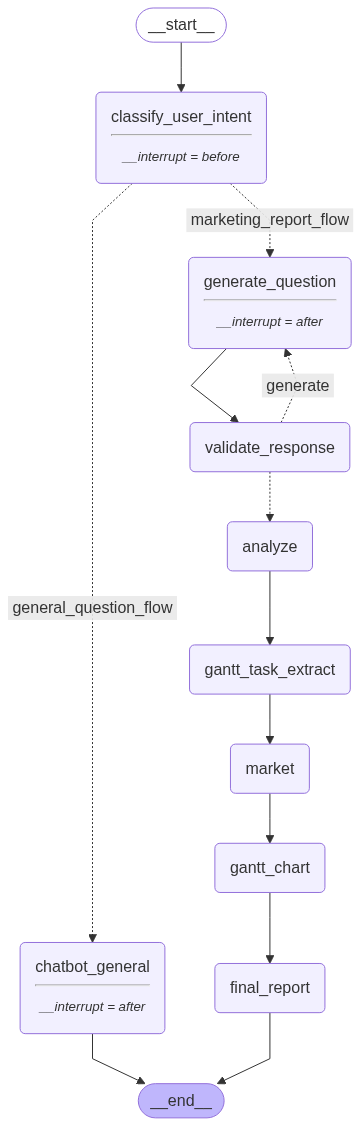

In [11]:
graph

# Conversation

In [ ]:
config = {"configurable": {"thread_id": "3"}}

# Initial state
initial_state = {
    "message": [],
    "information_needed": ["competitors"],
    "informationisEnough": False,
    "errors": [],
    "current_field": None,
    "final_report": None,

    "product_description": "Phần mềm hỗ trợ quản lý nhà hàng.",
    "product_type": "Phần mềm",
    "target_market_region": "Ngũ Hành Sơn, Đà Nẵng",
    "target_customer_profile": "Sinh viên và chủ quán cà phê.",
    "problem_to_solve": "Khách hàng gặp khó khăn trong việc quản lý hiệu quả do thiếu công cụ phù hợp.",
    "business_goal": "Có được 10 khách hàng B2B. Mục tiêu marketing: Tối đa hóa tương tác cho các chủ doanh nghiệp.",
    "budget": "Ngân sách dự kiến cho dự án là 2 tỷ đồng.",
    "timeline": "Dự án dự kiến mất khoảng 6 tháng để hoàn thành.",
    "your_unique_point": "Giao diện thân thiện với người dùng và tích hợp trí tuệ nhân tạo để hỗ trợ.",
    "competitors": None,

    "strategy_content": None,
    "market_analysis": None,
    "gantt_tasks": None,
    "gantt_chart": None,
    "intent": None
}


# Start conversation
graph.invoke(initial_state, config=config)

# Continue until done
while True:
    snapshot = graph.get_state(config)
    if snapshot.values.get("informationisEnough", False):
        print("\nChuyển sang phân tích")
        break

    try:
        answer = input("\nUser: ").strip()
        if answer.lower() in ['quit', 'exit']:
            break

        if answer:
            # Add user message to state
            current_state = snapshot.values
            current_state["message"].append(HumanMessage(content=answer))
            
            # Continue conversation
            graph.update_state(config, current_state)
            graph.invoke(None, config=config)

    except KeyboardInterrupt:
        break
    except Exception as e:
        print(f"Lỗi: {e}")

Classifying user intent...
Intent classified: marketing_report
Routing to marketing report flow...
1111111111111111111111

Generating question for field: product_description

Để hiểu rõ hơn về những gì bạn đang cung cấp, bạn có thể mô tả chi tiết hơn về sản phẩm hoặc dịch vụ của mình được không?


# Chatbot Testing

In [20]:
class State(TypedDict):
    messages: Annotated[list, add_messages]

In [21]:
api_key = os.getenv("GOOGLE_API_KEY")
os.environ["GOOGLE_API_KEY"] = api_key

def initialize_llm():
    """Initialize and return the LLM client"""
    return ChatGoogleGenerativeAI(
            model="gemini-2.0-flash",
            temperature=0,
            max_tokens=None,
            timeout=None,
            max_retries=2,
)

llm = initialize_llm()

In [22]:
def chatbot(state: State):
    return {"messages": [llm_with_tools.invoke(state["messages"])]}

search = GoogleSerperAPIWrapper()
search_tool = Tool(
    name="google_search",
    func=search.run,
    description="Use this tool to search Google using Serper API.",
    return_direct=True
)

tools = [search_tool]
llm_with_tools = llm.bind_tools(tools)

In [23]:
memory = MemorySaver()
graph_builder = StateGraph(State)
graph_builder.add_node("chatbot", chatbot)

tool_node = ToolNode(tools=[search_tool])
graph_builder.add_node("tools", tool_node)
graph_builder.add_conditional_edges("chatbot", tools_condition)
graph_builder.add_edge("tools", "chatbot")

graph_builder.set_entry_point("chatbot")
graph_builder.set_finish_point("chatbot")

graph = graph_builder.compile(
    checkpointer=memory,
    interrupt_after=["tools"],
)

config = {"configurable": {"thread_id": "1"}}

while True:
    user_input = input("User:")
    if user_input.lower() in ["q", "quit", "exit"]:
        print("GoodBye !!")
        break
    for event in graph.stream(
        {"messages": ("user", user_input)}, config, stream_mode="values"
    ):
        event["messages"][-1].pretty_print()

================================ Human Message =================================

what is the colors of the apple?
================================== Ai Message ==================================

Apples come in a variety of colors, including red, green, and yellow. Some varieties can also have a mix of these colors.
GoodBye !!


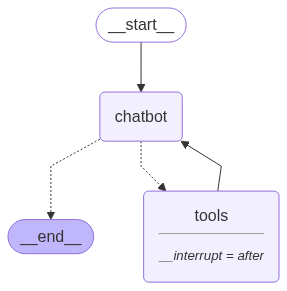

In [56]:
graph

In [13]:
search_query = "what going on in Campuchia and ThaiLand right now"
search_results = search_tool.func(search_query)

In [ ]:
def get_llm():
    """Get initialized Gemini LLM"""
    return ChatGoogleGenerativeAI(
        model="gemini-2.0-flash",
        temperature=0,
        max_tokens=None,
        timeout=None,
        max_retries=2,
    )

# ============================================================================
# STEP 5: Core Functions
# ============================================================================

def search_marketing_research(query):
    """Search for marketing research sources"""
    try:
        search = GoogleSerperAPIWrapper()
        enhanced_query = f"{query} marketing research report analysis trends 2024 2025"
        
        print(f"🔍 Searching for: {enhanced_query}")
        results = search.results(enhanced_query)
        
        if not results or 'organic' not in results:
            return None, f"❌ No search results found for '{query}'"
        
        organic_results = results['organic'][:5]
        urls = []
        search_summary = f"🔍 Found {len(organic_results)} results:\n\n"
        
        for i, result in enumerate(organic_results, 1):
            title = result.get('title', 'No title')
            url = result.get('link', '')
            snippet = result.get('snippet', 'No description')
            
            search_summary += f"{i}. **{title}**\n"
            search_summary += f"   URL: {url}\n"
            search_summary += f"   Summary: {snippet[:100]}...\n\n"
            urls.append(url)
        
        print(f"✅ Found {len(urls)} sources")
        return urls, search_summary
        
    except Exception as e:
        return None, f"❌ Search error: {str(e)}"

def read_webpage(url):
    """Read full content from a webpage"""
    try:
        if not url.startswith(('http://', 'https://')):
            url = 'https://' + url
        
        headers = {
            'User-Agent': 'Mozilla/5.0 (Windows NT 10.0; Win64; x64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/91.0.4472.124 Safari/537.36'
        }
        
        print(f"📄 Reading: {url[:60]}...")
        response = requests.get(url, headers=headers, timeout=30, allow_redirects=True)
        response.raise_for_status()
        
        soup = BeautifulSoup(response.content, 'html.parser')
        
        # Remove unwanted elements
        for element in soup(["script", "style", "nav", "footer", "aside", "header"]):
            element.decompose()
        
        # Extract main content
        main_content = []
        content_selectors = [
            'main', 'article', '[role="main"]', '.content', '.post-content', 
            '.entry-content', '.article-body', '.story-body', '.page-content'
        ]
        
        content_found = False
        for selector in content_selectors:
            elements = soup.select(selector)
            if elements:
                for element in elements:
                    text = element.get_text(separator=' ', strip=True)
                    if len(text) > 100:
                        main_content.append(text)
                if main_content:
                    content_found = True
                    break
        
        # Fallback to paragraphs
        if not content_found:
            for tag in ['h1', 'h2', 'h3', 'p']:
                elements = soup.find_all(tag)
                for element in elements:
                    text = element.get_text(separator=' ', strip=True)
                    if len(text) > 50:
                        main_content.append(text)
        
        # Clean and format
        full_text = '\n\n'.join(main_content)
        lines = []
        for line in full_text.split('\n'):
            cleaned_line = ' '.join(line.split())
            if cleaned_line and len(cleaned_line) > 10:
                lines.append(cleaned_line)
        
        cleaned_text = '\n'.join(lines)
        
        # Limit length for processing
        if len(cleaned_text) > 4000:
            cleaned_text = cleaned_text[:4000] + "...\n[Content truncated]"
        
        print(f"✅ Read {len(cleaned_text)} characters")
        return cleaned_text
        
    except Exception as e:
        print(f"❌ Error reading {url}: {str(e)}")
        return None

def analyze_content(content, query, llm):
    """Analyze content and extract marketing insights"""
    try:
        print("📊 Analyzing content for insights...")
        
        prompt = f"""
        Analyze this marketing research content for the query: "{query}"
        
        CONTENT:
        {content[:3000]}
        
        Provide analysis in this format:

        ## 📊 EXECUTIVE SUMMARY
        [2-3 sentences summarizing key findings]

        ## 🔍 KEY FINDINGS
        • [Finding 1]
        • [Finding 2] 
        • [Finding 3]

        ## 📈 MARKET TRENDS IDENTIFIED
        • [Trend 1]
        • [Trend 2]
        • [Trend 3]

        ## 💡 ACTIONABLE INSIGHTS
        • [Actionable insight 1]
        • [Actionable insight 2]
        • [Actionable insight 3]

        ## 📋 KEY STATISTICS/DATA
        • [Statistic 1]
        • [Statistic 2]
        • [Statistic 3]

        ## 🎯 MARKETING RECOMMENDATIONS
        • [Recommendation 1]
        • [Recommendation 2]
        • [Recommendation 3]

        Focus on practical, actionable marketing insights.
        """
        
        response = llm.invoke(prompt)
        print("✅ Analysis complete")
        return response.content
        
    except Exception as e:
        return f"❌ Analysis error: {str(e)}"

# ============================================================================
# STEP 6: Main Research Function
# ============================================================================
def research_marketing_trends(query):
    """
    Main function to research marketing trends by reading full web pages
    
    Args:
        query (str): Your marketing research question
        
    Returns:
        str: Complete research report with insights
    """
    print(f"🚀 STARTING MARKETING RESEARCH")
    print(f"Query: {query}")
    print("=" * 60)
    
    # Initialize LLM
    llm = get_llm()
    
    # Step 1: Search for sources
    print("\n🔍 STEP 1: Searching for sources...")
    urls, search_results = search_marketing_research(query)
    
    if not urls:
        return search_results
    
    # Step 2: Read web pages
    print("\n📄 STEP 2: Reading web page content...")
    successful_reads = []
    
    for i, url in enumerate(urls[:3]):  # Try first 3 URLs
        content = read_webpage(url)
        if content:
            successful_reads.append((url, content))
            print(f"✅ Successfully read source {i+1}")
        else:
            print(f"❌ Failed to read source {i+1}")
    
    if not successful_reads:
        return "❌ Could not read content from any sources. Try a different query."
    
    # Step 3: Analyze content
    print(f"\n📊 STEP 3: Analyzing {len(successful_reads)} sources...")
    
    # Combine content from multiple sources
    combined_content = ""
    source_list = ""
    
    for i, (url, content) in enumerate(successful_reads, 1):
        combined_content += f"\n--- SOURCE {i} ---\n{content}\n"
        source_list += f"{i}. {url}\n"
    
    # Get analysis
    analysis = analyze_content(combined_content, query, llm)
    
    # Step 4: Generate final report
    print("\n📋 STEP 4: Generating final report...")
    
    final_report = f"""
📊 MARKETING RESEARCH REPORT
Query: {query.upper()}
Generated: {datetime.now().strftime('%Y-%m-%d %H:%M')}

{analysis}

🔗 SOURCES ANALYZED:
{source_list}

📈 RESEARCH METHODOLOGY:
• Searched for recent marketing research and reports
• Read full web page content (not just snippets)  
• Analyzed {len(successful_reads)} comprehensive sources
• Extracted actionable insights using AI analysis

✅ Research completed successfully!
    """.strip()
    
    print("🎉 Research complete!")
    return display(Markdown(final_report))

# ============================================================================
# STEP 7: Quick Examples
# ============================================================================

def run_example():
    """Run a complete example"""
    
    # Setup
    if not os.getenv("GOOGLE_API_KEY"):
        setup_api_keys()
    
    # Example query
    query = "Latest social media marketing trends for small businesses in 2025"
    
    print("🎯 RUNNING EXAMPLE RESEARCH")
    print("=" * 50)
    
    result = research_marketing_trends(query)
    print("\n" + "="*60)
    print("📋 FINAL RESULTS:")
    print("="*60)
    print(result)
    
    return result

def quick_research(query):
    """Quick research function - just provide your query"""
    if not os.getenv("GOOGLE_API_KEY"):
        setup_api_keys()
    
    return research_marketing_trends(query)

# ============================================================================
# STEP 8: Ready to Use!
# ============================================================================

print("🎉 Simple Marketing Research Agent Ready!")
print("\n💡 USAGE:")
print("1. Run: run_example()  # See full example")
print('2. Run: quick_research("your marketing question")')
print("\n🔧 FEATURES:")
print("✅ Searches for marketing research sources")
print("✅ Reads FULL web page content (not snippets)")
print("✅ Analyzes multiple sources")
print("✅ Provides structured insights & recommendations")

# ============================================================================
# RUN THE EXAMPLE NOW!
# ============================================================================

# Uncomment the next line to run example immediately:
# run_example()

🎉 Simple Marketing Research Agent Ready!

💡 USAGE:
1. Run: run_example()  # See full example
2. Run: quick_research("your marketing question")

🔧 FEATURES:
✅ Searches for marketing research sources
✅ Reads FULL web page content (not snippets)
✅ Analyzes multiple sources
✅ Provides structured insights & recommendations


In [65]:
quick_research("insights khách hàng trong marketing online 2022")

🚀 STARTING MARKETING RESEARCH
Query: insights khách hàng trong marketing online 2022

🔍 STEP 1: Searching for sources...
🔍 Searching for: insights khách hàng trong marketing online 2022 marketing research report analysis trends 2024 2025
✅ Found 5 sources

📄 STEP 2: Reading web page content...
📄 Reading: https://blog.hubspot.com/marketing/hubspot-blog-marketing-in...
✅ Read 4023 characters
✅ Successfully read source 1
📄 Reading: https://www.askattest.com/blog/articles/market-research-tren...
❌ Error reading https://www.askattest.com/blog/articles/market-research-trends: 403 Client Error: Forbidden for url: https://www.askattest.com/blog/articles/market-research-trends
❌ Failed to read source 2
📄 Reading: https://www.deloittedigital.com/nl/en/insights/perspective/m...
✅ Read 4023 characters
✅ Successfully read source 3

📊 STEP 3: Analyzing 2 sources...
📊 Analyzing content for insights...
✅ Analysis complete

📋 STEP 4: Generating final report...
🎉 Research complete!


📊 MARKETING RESEARCH REPORT
Query: INSIGHTS KHÁCH HÀNG TRONG MARKETING ONLINE 2022
Generated: 2025-07-28 00:00

## 📊 EXECUTIVE SUMMARY

This report, based on a survey of over 1,700 global marketers, highlights the increasing importance of AI in content creation, research, and data analysis. Marketers are leveraging AI to meet growing content demands and improve efficiency. Understanding and adopting these AI-driven strategies is crucial for staying competitive in the evolving digital marketing landscape.

## 🔍 KEY FINDINGS
• AI is heavily used for content creation, research, and data analysis by marketers.
• Marketers are using AI to repurpose content, such as turning blog posts into video scripts.
• AI helps marketing teams increase content output without increasing headcount.

## 📈 MARKET TRENDS IDENTIFIED
• **Increased AI Adoption:** Marketers are rapidly adopting AI tools for various tasks.
• **Content Repurposing:** AI is being used to efficiently repurpose existing content into different formats.
• **Data-Driven Decision Making:** AI is assisting in data analysis and reporting, leading to more informed marketing strategies.

## 💡 ACTIONABLE INSIGHTS
• **Invest in AI Tools:** Explore and invest in AI tools that can assist with content creation, research, and data analysis.
• **Repurpose Existing Content:** Utilize AI to repurpose existing content into different formats to maximize its reach and impact.
• **Focus on AI Training:** Train your marketing team on how to effectively use AI tools to improve their productivity and efficiency.

## 📋 KEY STATISTICS/DATA
• 43% of marketers use generative AI for content creation.
• 34% of marketers use generative AI for market research.
• 40% of marketers use generative AI to learn how to do things (e.g., Excel functions).

## 🎯 MARKETING RECOMMENDATIONS
• **Implement AI-powered content creation tools:** Use AI to generate blog posts, social media updates, and video scripts.
• **Utilize AI for market research:** Leverage AI to analyze market trends, identify customer segments, and understand competitor strategies.
• **Automate data analysis with AI:** Use AI to analyze marketing data, track campaign performance, and identify areas for improvement.

🔗 SOURCES ANALYZED:
1. https://blog.hubspot.com/marketing/hubspot-blog-marketing-industry-trends-report
2. https://www.deloittedigital.com/nl/en/insights/perspective/marketing-trends-2025.html


📈 RESEARCH METHODOLOGY:
• Searched for recent marketing research and reports
• Read full web page content (not just snippets)  
• Analyzed 2 comprehensive sources
• Extracted actionable insights using AI analysis

✅ Research completed successfully!